### Do different languages encode different types of information? Can we gain traction on this question using neural models?

**Author**: Ben Peloquin

**Date**: 20190610

My [previous work](https://osf.io/ejsg6/) has examined efficiency-based explanations for the distributational regularities we see across natural languages. That work explored the question -- "why do we see commonalities between languages." This current analysis examines the inverse -- "in what ways do languages encode information differently." This line of inquery follows a rich set of philosophical and experimental investigations on [**linguistic relativism**](https://plato.stanford.edu/archives/sum2015/entries/relativism/supplement2.html) -- the degree to which the language you speak *influences* how you think about the world.

To instantiate these questions we adopt a *grounded language* setting in which language is paired with some *ground-truth* representation. In the current work, we'll take `images` as our "ground-truth" representations and `captions` as our linguistic representation.

`Part I` of this project implements an image captioning model with visual attention as described in [Xu et al. (2017)](https://arxiv.org/pdf/1502.03044.pdf). My implementation can be found on my [github](https://github.com/benpeloquin7/sapir_image_captioning) and the trained models are stored remotely.

`Part II` of this project is contained in this notebook and involves a set of exploratory analysis focused on whether we can describe diffrences between languages.

### Data and model

*  `Dataset`: multi30k -- image captionning dataset with independently generated captions in `English` and `German`
  * 30k images
  * Each image has 5 English captions and 5 German captions
* `Model`: Neural image captioning model with visual attention.
  * For our purposes the `visual attention` component of the model can be thought of as a saliency map over pixel space. Each saliency map is a distribution over pixels, which is used during token generation. Intuitively, it describes the pixels in the image that are most relevant for generating token $c_i \in C$ in caption $C$
  

### Analysis plan

I conduct 3 exploratory analysis.

1. Do English and Gemran organize the set of images differently?
  * Having trained our image captioning models we encode images in langauge represernations by averaging LSTM hidden states for each image. Each image is represented as a `(512, )` vector. We're interested in whether we can describe differences between the representational spaces for English and German.

2. 

In [13]:
# Set-up
from collections import defaultdict
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd
import pickle
import sys
import tqdm

from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import seaborn as sns
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from spacy.lang.de.examples import sentences
from spacy.tokenizer import Tokenizer

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sapir_image_captions import GLOBAL_TOKENS, SOS_TOKEN, EOS_TOKEN, PAD_TOKEN
from sapir_image_captions.checkpoints import load_checkpoint
from sapir_image_captions.multi_30k.dataset import CaptionTask2Dataset
from sapir_image_captions.models import batch_beam_search_caption_generation, beam_search_caption_generation
from sapir_image_captions.utils import text2tensor, tensor2text, remove_tokens

plt.style.use('ggplot')

LANGUAGE_HIDDEN_DIM = 512

I've stored the data on my local machine. If you'd access to the trained models I'm happy to distribute. However, you will not be able to run this code on your local machine.

In [2]:
data_dir = "/Users/benpeloquin/Data/projects/sapir_image_captions/trained_models/model_as_participant_out_20190520"
model_path_creater = lambda language, version: "model_data_{}_{}_2016.pickle".format(language, version)

IMAGES_DIR = "/Users/benpeloquin/Data/general/multi30k/data/task2/image_splits/test_2016_images.txt"
IMAGES_CONTAINER = "/Users/benpeloquin/Data/general/multi30k/flickr30k-images/"

In [3]:
# Load models
de_fp_1 = os.path.join(data_dir, model_path_creater("de", 1))
en_fp_1 = os.path.join(data_dir, model_path_creater("en", 1))
de_fp_2 = os.path.join(data_dir, model_path_creater("de", 2))
en_fp_2 = os.path.join(data_dir, model_path_creater("en", 2))
de_fp_3 = os.path.join(data_dir, model_path_creater("de", 3))
en_fp_3 = os.path.join(data_dir, model_path_creater("en", 3))
de_fp_4 = os.path.join(data_dir, model_path_creater("de", 4))
en_fp_4 = os.path.join(data_dir, model_path_creater("en", 4))
de_fp_5 = os.path.join(data_dir, model_path_creater("de", 5))
en_fp_5 = os.path.join(data_dir, model_path_creater("en", 5))

In [4]:
# model 1
with open(de_fp_1, "rb") as fp:
    d_de_1 = pickle.load(fp)
with open(en_fp_1, "rb") as fp:
    d_en_1 = pickle.load(fp)
# model 2
with open(de_fp_2, "rb") as fp:
    d_de_2 = pickle.load(fp)
with open(en_fp_2, "rb") as fp:
    d_en_2 = pickle.load(fp)
# model 3
with open(de_fp_3, "rb") as fp:
    d_de_3 = pickle.load(fp)
with open(en_fp_3, "rb") as fp:
    d_en_3 = pickle.load(fp)
# model 4
with open(de_fp_4, "rb") as fp:
    d_de_4 = pickle.load(fp)
with open(en_fp_4, "rb") as fp:
    d_en_4 = pickle.load(fp)
# model 5
with open(de_fp_5, "rb") as fp:
    d_de_5 = pickle.load(fp)
with open(en_fp_5, "rb") as fp:
    d_en_5 = pickle.load(fp)

In [5]:
# We'll use spacy for POS tagging
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

def get_all_datas(model, parser=en_nlp):
    """Generic helper function for extracting various 
    image representations.
    
    
    Parameters
    ----------
    model: dict
        One of model_data_{}_{}_2016.pickle objects.
    parser: spacy parser
        Returned from spacy.load()
    
    Returns
    -------
    dict
        Average/individual language hiddens, 
        recon captions, recon pos, recon alpha
    
    """
    all_avg_hiddens = []
    all_hiddens = []
    all_tokens = []
    all_pos = []
    all_alphas = []
    all_avg_alphas = []
    
    n_batches = len(model["language_hiddens"])
    for batch_idx in tqdm.tqdm(range(n_batches)):
        # Hiddens
        for sent_hiddens in model["language_hiddens"][batch_idx]:
            sent_hiddens = sent_hiddens[1:-1]
            avg_hiddens_vector = sent_hiddens.mean(0)
            all_avg_hiddens.append(avg_hiddens_vector)
            for token_hiddens in sent_hiddens:
                all_hiddens.append(token_hiddens)                

        # Tokens / POS
        for sent_text in model["recon_captions"][batch_idx]:
            d_parsed = parser(sent_text)
            all_tokens.append([parsed.text for parsed in d_parsed])
            all_pos.append([parsed.pos_ for parsed in d_parsed])
        
        # Alphas (attention maps)
        for sent_alphas in model["alphas"][batch_idx]:
            all_avg_alphas.append(sent_alphas.mean(0) / sent_alphas.mean(0).sum())
            all_alphas.append(sent_alphas)
            
    return {"all_avg_hiddens": all_avg_hiddens, 
            "all_hiddens": all_hiddens, 
            "all_tokens": all_tokens, 
            "all_pos": all_pos, 
            "all_alphas": all_alphas,
            "all_avg_alphas": all_avg_alphas}

In [6]:
# Get data
models = [('en1', d_en_1), ('en2', d_en_2), ('en3', d_en_3), ('en4', d_en_4), ('en5', d_en_5), 
          ('de1', d_de_1), ('de2', d_de_2), ('de3', d_de_3),('de4', d_de_4), ('de5', d_de_5)]

all_data = {}
for model_nam, model in models:
    if 'en' in model_nam:
        all_data[model_nam] = get_all_datas(model, en_nlp)
    elif 'de' in model_nam:
        all_data[model_nam] = get_all_datas(model, de_nlp)
    else:
        raise Exception("How did this happen???")
        
# Resnet encodings
X_images = np.concatenate(d_en_1["image_hiddens"])
all_data["image"] = {"all_avg_hiddens": X_images}

100%|██████████| 16/16 [00:11<00:00,  1.40it/s]


### Inspectig a single image

Let's just look at a single image to get acqainted

In [7]:
# Visualization helpers / loaders

def get_caption(idx, data):
    return data[idx]

def get_image_path(idx, images_fp=IMAGES_CONTAINER):
    """Indexing into test images..."""
    images = pd.read_csv(images_fp, sep=" ", header=None) \
        .values \
        .squeeze() \
        .tolist()
    return images[idx]

def load_image(idx, images_directory=IMAGES_DIR, images_container=IMAGES_CONTAINER):
    """Returns a numpy array of the image."""
    image_name = get_image_path(idx, images_directory)
    image_fp = os.path.join(images_container, image_name)
    return plt.imread(image_fp)

def visualize_image(idx, images_fp=IMAGES_DIR):
    return plt.imshow(load_image(idx, images_fp))

a man wearing a black hat and sunglasses is looking at the camera .
a man wearing sunglasses and a hat is holding a camera .
a man wearing a hat and a hat .
a man with a beard wearing a hat .
a man smoking a cigarette .
einen mann , der einen hut trägt .
ein mann mit brille .
ein mann mit brille und sonnenbrille .
ein mann mit hut und brille .
ein mann mit brille und brille schaut in die kamera .


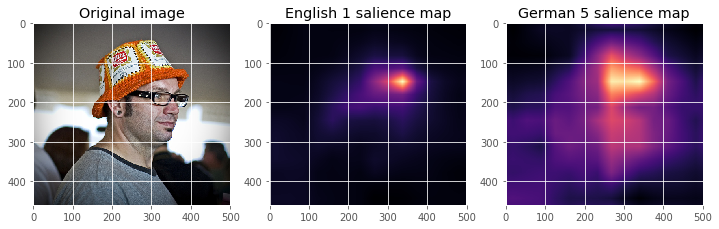

In [8]:
plt.figure(figsize=(12, 6))
all_non_image_models = ["{}{}".format(lang, i) for lang in ["en", "de"] for i in range(1, 6)]
for model_name in all_non_image_models:
    print(' '.join(all_data[model_name]["all_tokens"][0]))

plt.subplot(1, 3, 1)
plt.title("Original image")
visualize_image(0)
plt.subplot(1, 3, 2)
plt.title("English 1 salience map")
plt.imshow(resize(np.array(all_data["en1"]["all_avg_alphas"][0]), load_image(0).shape[:2]), cmap="magma")
plt.subplot(1, 3, 3)
plt.title("German 5 salience map")
plt.imshow(resize(np.array(all_data["de5"]["all_avg_alphas"][0]), load_image(0).shape[:2]), cmap="magma")

Let's visualize the representations.

In [18]:
# We'll use PCA for dim reduction
pca_var_explained = PCA(n_components=LANGUAGE_HIDDEN_DIM)
pca = PCA(n_components=2)
pca_hold = {"image": (pca.fit_transform(X_images), )}
for model_name in tqdm.tqdm(all_data.keys()):
    X_curr = np.array(all_data[model_name]["all_avg_hiddens"])
    m = pca.fit(X_curr)
    # Grab variance explained by first two principle components
    var_explained = pca_var_explained.fit(X_curr).explained_variance_ratio_[:2].sum()
    out = pca.transform(X_curr)
    pca_hold[model_name] = (out, var_explained)

100%|██████████| 11/11 [01:16<00:00,  6.94s/it]


In [23]:
# Metas
en1_pca0 = [x[0] for x in pca_hold["image"][0]]
en1_pca1 = [x[1] for x in pca_hold["image"][0]]
resnet_xmin = np.argmin(en1_pca0)
resnet_xmax = np.argmax(en1_pca0)
resnet_ymin = np.argmin(en1_pca1)
resnet_ymax = np.argmax(en1_pca1)

special_images_idxs = [0, resnet_xmin, resnet_xmax, resnet_ymin, resnet_ymax]
special_image_idxs_colors = ["red", "blue", "green", "orange" , "purple"]
n_models = len(pca_hold)
# n_rows = n_cols = int(np.ceil(np.sqrt(len(pca_hold.keys()))))
n_rows, n_cols = 4, 2
n_normal = len(en1_pca0) - len(special_images_idxs)
colors = []
sizes = []
for idx in range(len(en1_pca0)):
    col = special_image_idxs_colors.pop() if idx in special_images_idxs else "grey"
    colors.append(col)
    size = 200 if idx in special_images_idxs else 50
    sizes.append(size)

Let's visualize the representational space from ResNet encodings.

Note that I'm coloring some images arbitrarily for comparison among the different models.

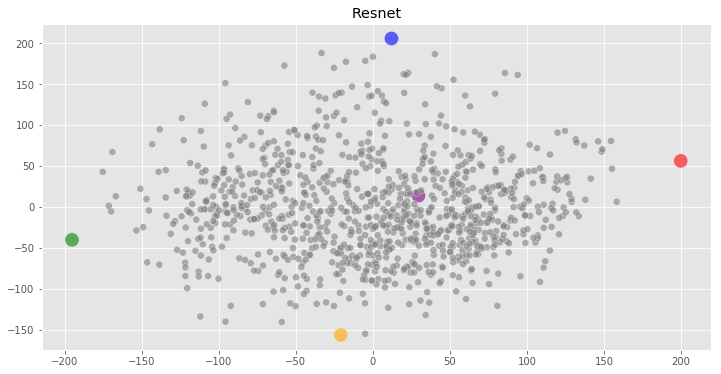

In [24]:
plt.figure(figsize=(12, 6))
plt.title("{}".format("Resnet"))
X = pca_hold["image"][0]
plt.scatter(X[:, 0], X[:, 1], 
            c=colors, cmap='hsv', alpha=0.6, edgecolors='w', s=sizes)

English

100%|██████████| 11/11 [00:00<00:00, 85.60it/s]


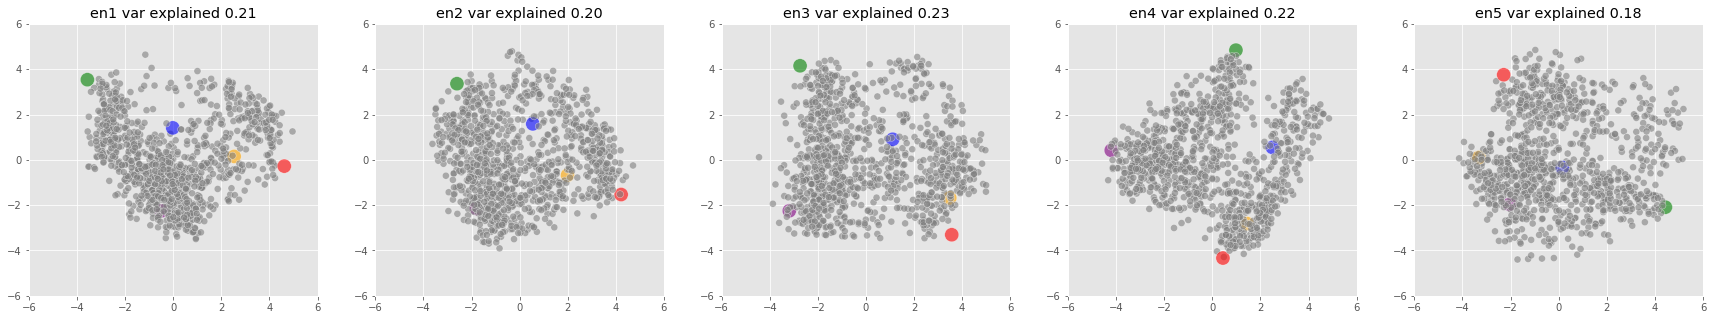

In [32]:
i = 1
plt.figure(figsize=(30, 5))
for model_name in tqdm.tqdm(pca_hold.keys()):
    if "en" in model_name:
        X = pca_hold[model_name][0]
        plt.subplot(1, 5, i)
        plt.title("{} var explained {:.2f}".format(model_name, pca_hold[model_name][1]))
        plt.scatter(X[:, 0], X[:, 1], 
            c=colors, cmap='hsv', alpha=0.6, edgecolors='w', s=sizes)
        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
        i += 1

German

100%|██████████| 11/11 [00:00<00:00, 85.89it/s]


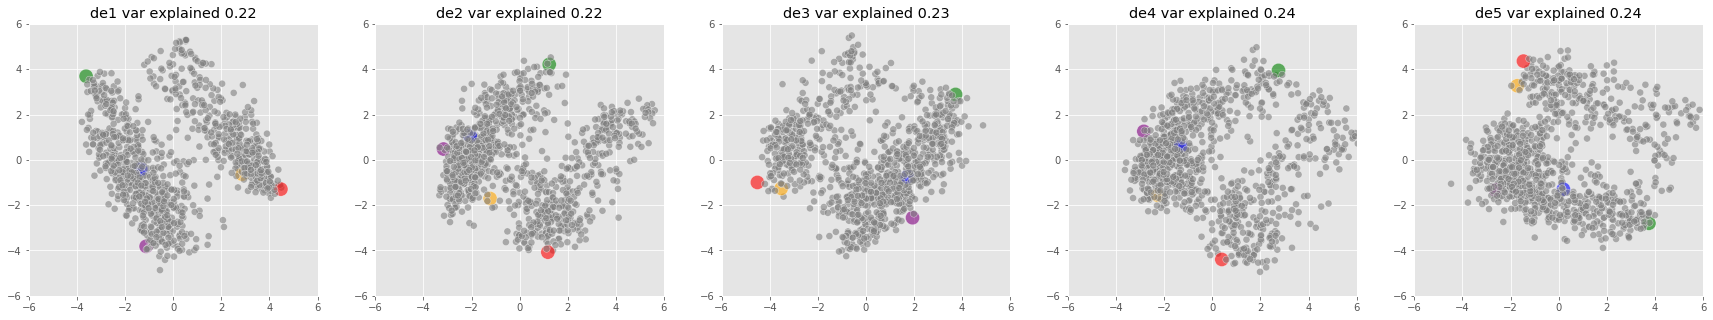

In [33]:
i = 1
plt.figure(figsize=(30, 5))
for model_name in tqdm.tqdm(pca_hold.keys()):
    if "de" in model_name:
        X = pca_hold[model_name][0]
        plt.subplot(1, 5, i)
        plt.title("{} var explained {:.2f}".format(model_name, pca_hold[model_name][1]))
        plt.scatter(X[:, 0], X[:, 1], 
            c=colors, cmap='hsv', alpha=0.6, edgecolors='w', s=sizes)
        plt.xlim(-6, 6)
        plt.ylim(-6, 6)
        i += 1

Informally, there definitely appear to be differences between the visual-only encodings. Even between languages it kind of looks like German may partition the images in to two distinct clusters while in English the partition is a bit noiser.

To try to compare theses spaces quantitiatvely, let's look at relative image distances in these spaces. We can't really compare these representational spaces apples-to-apples, but we can consider relative distances. That is, if image A is closest to image B in space 1, but image C is closest to image B in space 2 that tells us that the two spaces are organizing the images distinctly.

In [34]:
def get_image_by_image_corrs(X):
    x = np.corrcoef(np.array(X))
    return x[np.triu_indices(len(x), k=1)]

In [35]:
d_image_corrs = {}
for model_name in tqdm.tqdm(all_data.keys()):
    d_image_corrs[model_name] = get_image_by_image_corrs(all_data[model_name]["all_avg_hiddens"])

100%|██████████| 11/11 [00:10<00:00,  1.10it/s]


In [41]:
# Helpers for model comparison
non_image_combs = [
    # en-en
    ("en1", "en2"),
    ("en1", "en3"),
    ("en1", "en4"),
    ("en1", "en5"),
    ("en2", "en3"),
    ("en2", "en4"),
    ("en2", "en5"),
    ("en3", "en4"),
    ("en3", "en5"),
    ("en4", "en5"),
    # de-de
    ("de1", "de2"),
    ("de1", "de3"),
    ("de1", "de4"),
    ("de1", "de5"),
    ("de2", "de3"),
    ("de2", "de4"),
    ("de2", "de5"),
    ("de3", "de4"),
    ("de3", "de5"),
    ("de4", "de5"),
    # en-de
    ("en1", "de2"),
    ("en1", "de3"),
    ("en1", "de4"),
    ("en1", "de5"),
    ("en2", "de2"),
    ("en2", "de3"),
    ("en2", "de4"),
    ("en2", "de5"),
    ("en3", "de2"),
    ("en3", "de3"),
    ("en3", "de4"),
    ("en3", "de5"),
    ("en4", "de2"),
    ("en4", "de3"),
    ("en4", "de4"),
    ("en4", "de5"),
    ("en5", "de2"),
    ("en5", "de3"),
    ("en5", "de4"),
    ("en5", "de5")
]

combs = [
    # en-en
    ("en1", "en2"),
    ("en1", "en3"),
    ("en1", "en4"),
    ("en1", "en5"),
    ("en2", "en3"),
    ("en2", "en4"),
    ("en2", "en5"),
    ("en3", "en4"),
    ("en3", "en5"),
    ("en4", "en5"),
    # de-de
    ("de1", "de2"),
    ("de1", "de3"),
    ("de1", "de4"),
    ("de1", "de5"),
    ("de2", "de3"),
    ("de2", "de4"),
    ("de2", "de5"),
    ("de3", "de4"),
    ("de3", "de5"),
    ("de4", "de5"),
    ("de1", "de5"),
    ("de2", "de3"),
    ("de2", "de4"),
    ("de2", "de5"),
    ("de3", "de4"),
    ("de3", "de5"),
    ("de4", "de5"),
    # en-de
    # de-de
    ("en1", "de1"),
    ("en2", "de2"),
    ("en3", "de3"),
    ("en4", "de4"),
    ("en5", "de5"),
    # image-en
    ("image", "en1"),
    ("image", "en2"),
    ("image", "en3"),
    ("image", "en4"),
    ("image", "en5"),
    # image-de
    ("image", "de1"),
    ("image", "de2"),
    ("image", "de3"),
    ("image", "de4"),
    ("image", "de5")
]
d_corr_res = []
for comb in combs:
    a, b = comb
    d_corr_res.append({
        "datas": "{}-{}".format(*comb),
        "r": np.corrcoef(d_image_corrs[a], d_image_corrs[b])[0][1]
    })
    
df_corr_res = pd.DataFrame(d_corr_res)

In [42]:
# minor preprocessing
def get_typ(x):
    a, b = x.split("-")[0][:2], x.split("-")[1][:2]
    return "{}-{}".format(a, b)
    
df_corr_res["type"] = df_corr_res["datas"].apply(get_typ)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

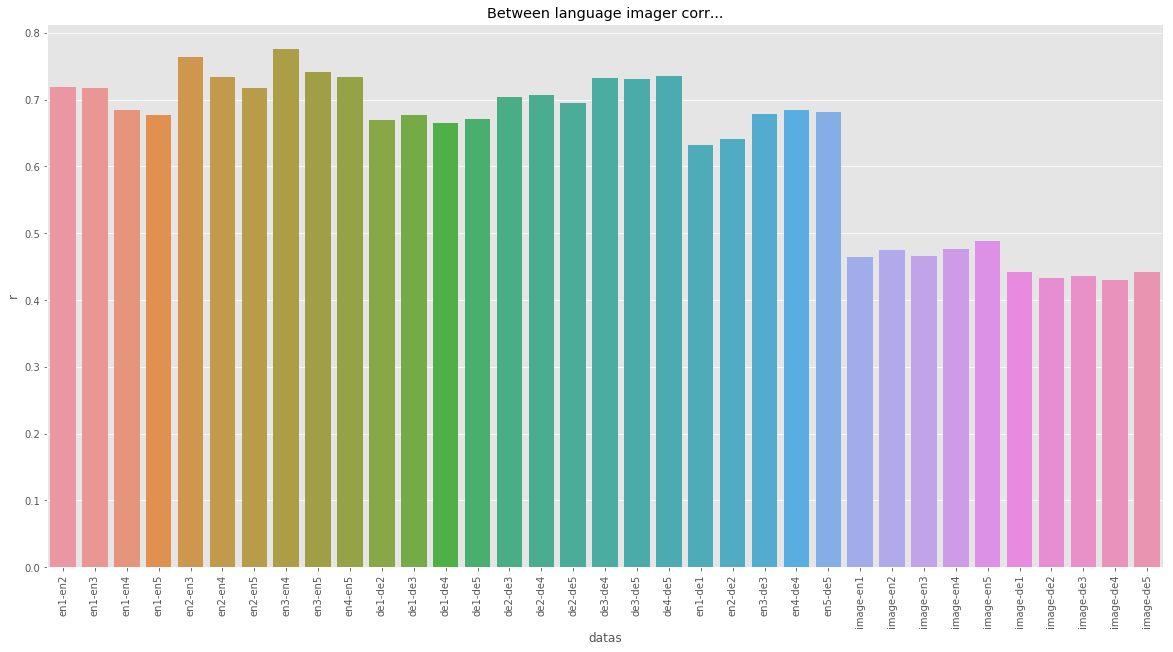

In [43]:
plt.figure(figsize=(20, 10))
plt.title("Between language imager corr...")
sns.barplot(x="datas", y="r", data=df_corr_res)
plt.xticks(rotation=90)

(0, 1)

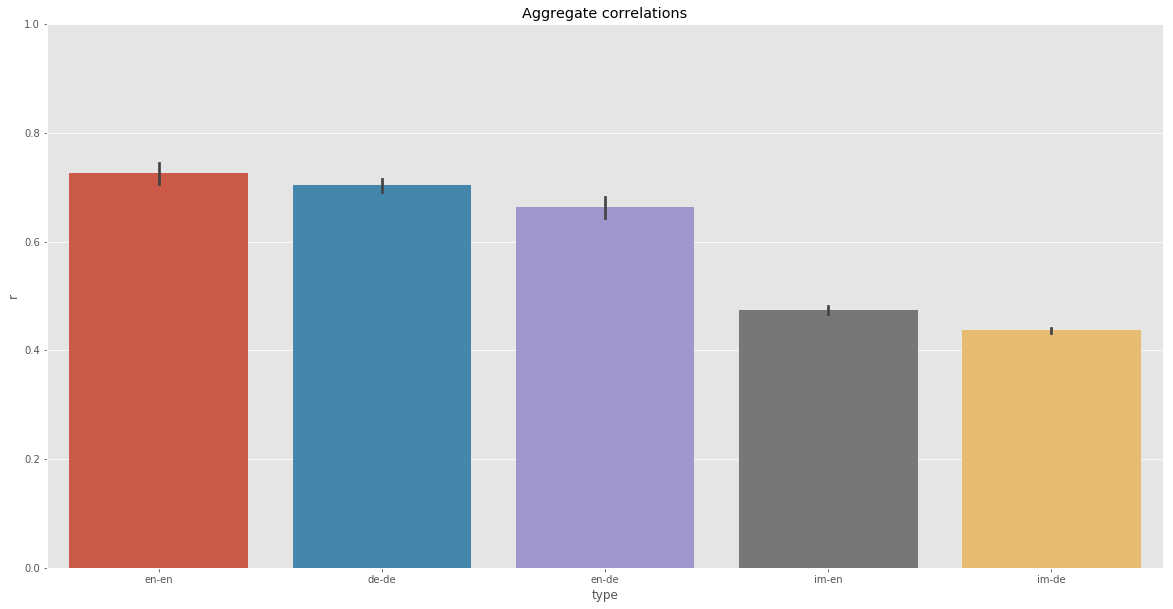

In [44]:
plt.figure(figsize=(20, 10))
plt.title("Aggregate correlations")
sns.barplot(x="type", y="r", ci=95, data=df_corr_res)
plt.ylim(0, 1)

In the above analysis we examined how similar the representational spaces between models appears to be. In general we see that langugaes of the same type tend to have the **most similar** organizations `(en-en)` and `(de-de)` and languages in general tend to organize thes spaces much differently from the image encoder alone (`en-de` vs `im-en` and `de-en`).

### Analyzing "clusteriness"

While I'm not super happy about this analysis, one thing we can look at is how many clusters each encoding induces. While there are several ways we might do this, here I'm just going run K-means, varying `K`. We can use `silhoutte score` to assess the quality of the clusters. [`silhoutte score`](https://en.wikipedia.org/wiki/Silhouette_(clustering)) essentially scores the between and withing cluster variance.

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [46]:
d_kmeans = defaultdict(dict)
n_sims = 10
ks = range(2, 11)
pbar = tqdm.tqdm(total=n_sims*len(all_data.keys())*len(ks))
for sim in range(n_sims):
    for k in ks:
        for model_name in all_data.keys():
            if model_name == "image":
                continue
            X = all_data[model_name]["all_avg_hiddens"]
            clusterer = KMeans(n_clusters=k, random_state=sim)
            cluster_labels = clusterer.fit_predict(X)
            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette_avg = silhouette_score(X, cluster_labels)
            d_kmeans[model_name][k] = [silhouette_avg, cluster_labels, sim]
            pbar.update()
pbar.close()

 91%|█████████ | 900/990 [05:24<00:43,  2.09it/s]


In [47]:
d_kmeans_silhoutes = []
for model_name in d_kmeans.keys():
    for k in d_kmeans[model_name].keys():
        d_kmeans_silhoutes.append({
            'model_name': model_name,
            'k': k,
            'score': d_kmeans[model_name][k][0],
            'sim': d_kmeans[model_name][k][2]
        })
df_kmeans_silhoutes = pd.DataFrame(d_kmeans_silhoutes)
df_kmeans_silhoutes["lang"] = df_kmeans_silhoutes["model_name"].apply(lambda x: x[:2])

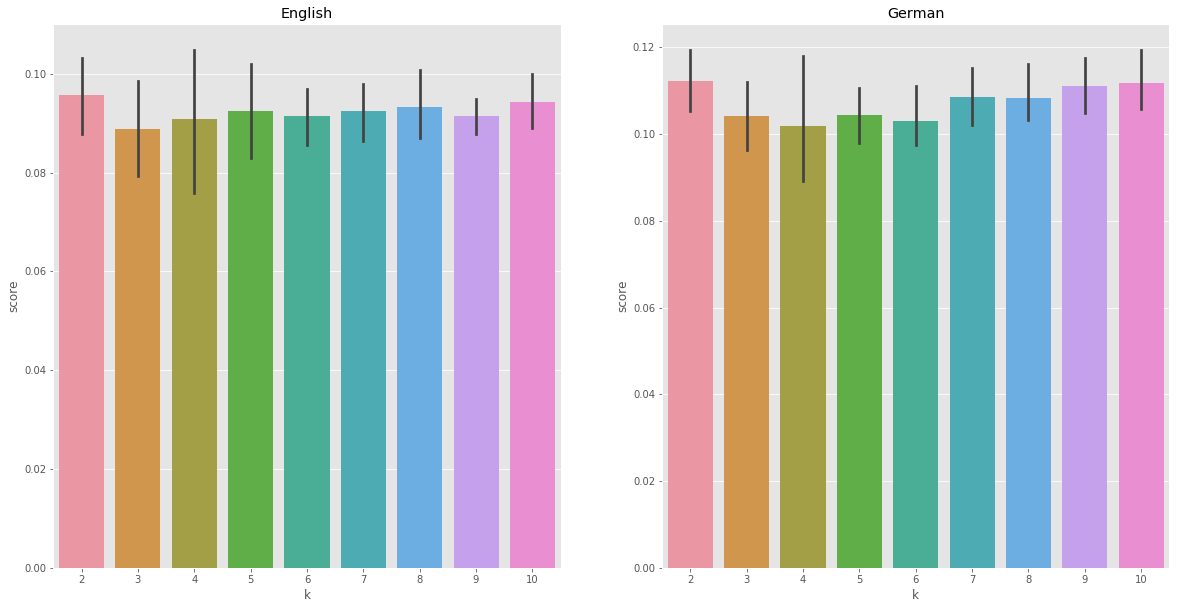

In [48]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("English")
sns.barplot(x="k", y="score", ci=95, data=df_kmeans_silhoutes[df_kmeans_silhoutes["lang"]=="en"])
plt.subplot(1, 2, 2)
plt.title("German")
sns.barplot(x="k", y="score", ci=95, data=df_kmeans_silhoutes[df_kmeans_silhoutes["lang"]=="de"])

En1


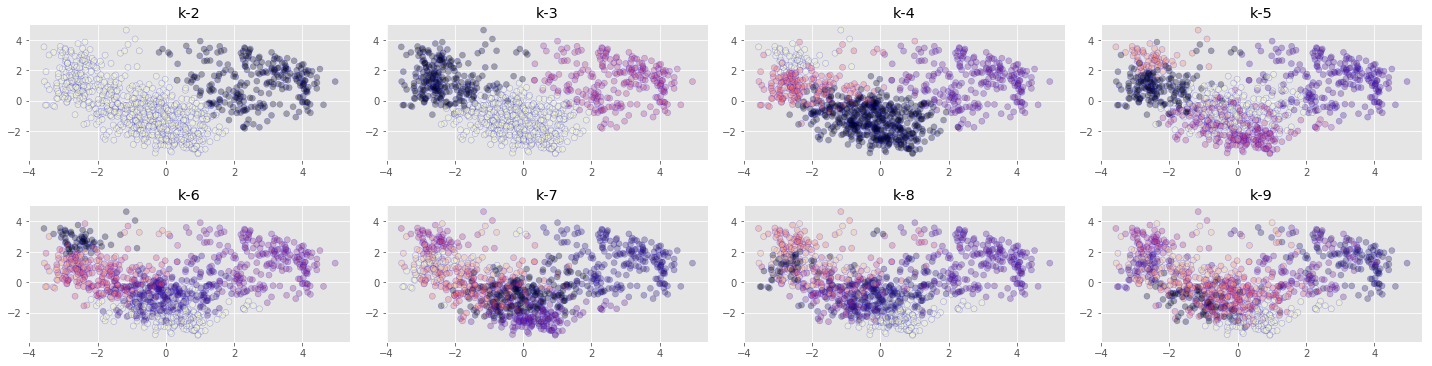

In [50]:
print("En1")
plt.figure(figsize=(20, 10))
for i, k in enumerate(list(d_kmeans["en1"].keys())[:8], 1):
    plt.subplot(4, 4, i)
    X = pca_hold["en1"][0]
    plt.title("k-{}".format(k))
    plt.scatter(X[:, 0], X[:, 1], 
                c=d_kmeans["en1"][k][1], cmap='magma', 
                alpha=0.3, edgecolors='b')
plt.tight_layout()

De1


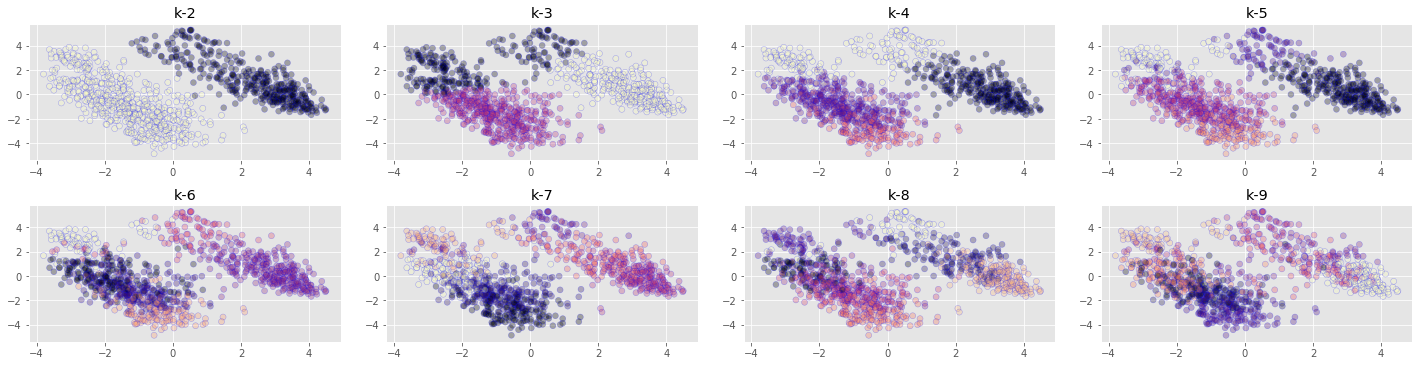

In [52]:
print("De1")
plt.figure(figsize=(20, 10))
for i, k in enumerate(list(d_kmeans["de1"].keys())[:8], 1):
    plt.subplot(4, 4, i)
    X = pca_hold["de1"][0]
    plt.title("k-{}".format(k))
    plt.scatter(X[:, 0], X[:, 1], 
                c=d_kmeans["de1"][k][1], cmap='magma', 
                alpha=0.3, edgecolors='b')
plt.tight_layout()

This concludes our coarse-grained anlaysis of the representional spaces induced by English vs German. There are indications that the languages organize the image space differently, however our anaysis does quite have the precision to quantify this numerically.

# Analyzing alphas

The image-captioning models we considered use attention over pixel space during token generation. We can assess the degree to which attention distributsion differ between languages. 

For fun let's just visualize the alpha distribution for an example caption.

In [72]:
print(all_data.keys())
len(all_data["en1"]["all_alphas"][0])

dict_keys(['en1', 'en2', 'en3', 'en4', 'en5', 'de1', 'de2', 'de3', 'de4', 'de5', 'image'])


14

In [73]:
def visualize_alphas_(alphas, tokens, img_idx, alpha=0.65):
    img = load_image(img_idx)
    n_tokens = alphas.shape[0]
    for token in range(n_tokens):
        plt.subplot(np.ceil(np.sqrt(n_tokens)), np.ceil(np.sqrt(n_tokens)), token+1)
        curr_alphas = resize(alphas[token, :], img.shape[:2])
        plt.title("{}".format(tokens[token]))
        plt.imshow(img)
        plt.imshow(curr_alphas, cmap="magma", alpha=alpha)
    return

def visualize_alphas(img_idx, lang):
    img = load_image(img_idx)
    alphas = all_data[lang]["all_alphas"][img_idx]
    tokens = all_data[lang]["all_tokens"][img_idx]
    visualize_alphas_(alphas, tokens, img_idx)

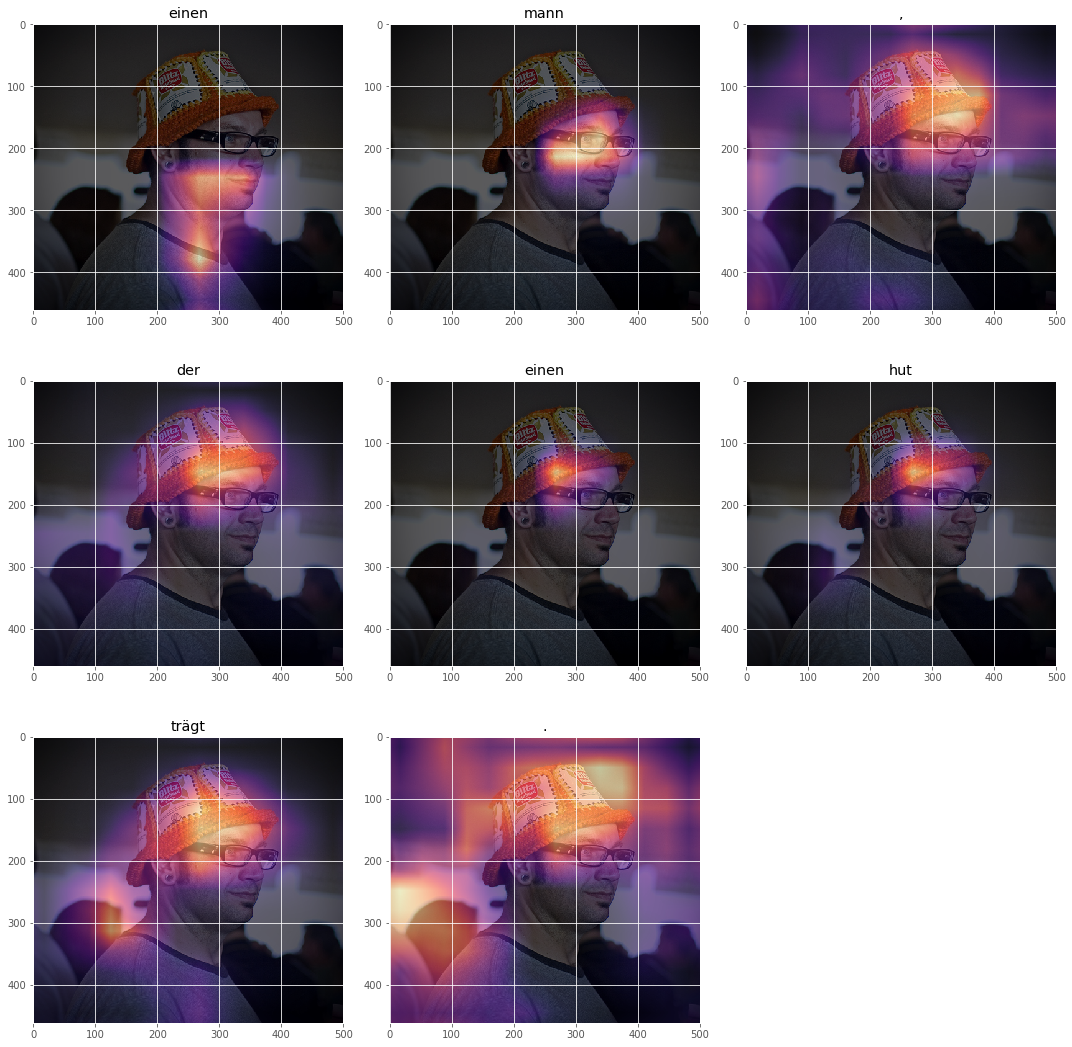

In [74]:
plt.figure(figsize=(15, 15))
visualize_alphas(0, "de1")
plt.tight_layout()

Now we'll summarize these separate distributions and renormalize to get another single alpha distribution representation of each image.

Since each attention map is a distribution over pixels we'll use KL-divergence the measure the differences between models.

In [75]:
# KL for single image
get_kl(all_data["en1"]["all_avg_alphas"][0], all_data["de1"]["all_avg_alphas"][0])

0.14041658849927197

In [76]:
def get_kl(d1, d2):
    return np.sum(d1 * np.log(d1 / d2))

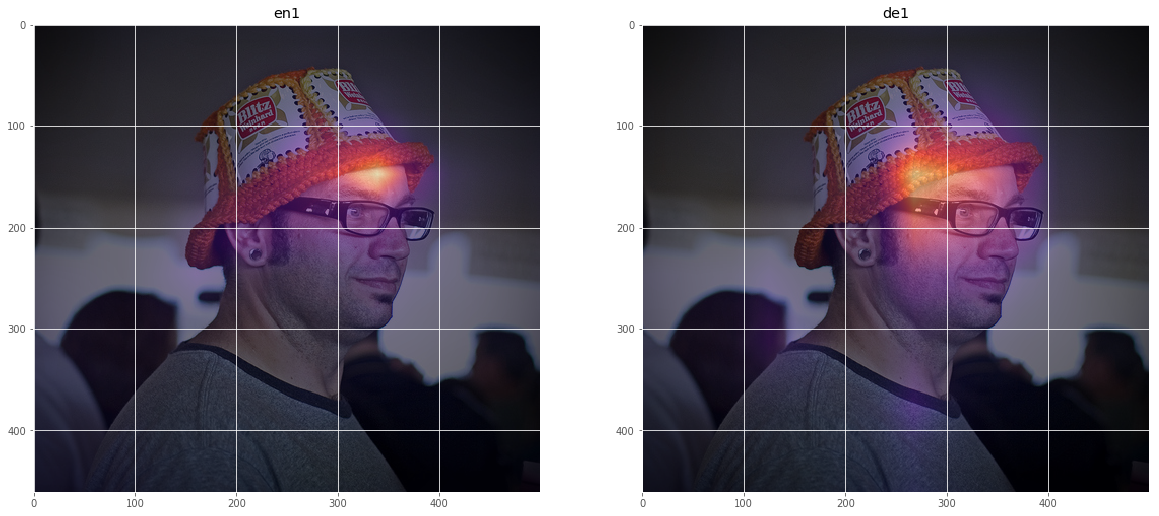

In [77]:
img = load_image(0)
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
visualize_image(0)
plt.title("en1")
plt.imshow(resize(all_data["en1"]["all_avg_alphas"][0], img.shape[:2]), alpha=0.6, cmap="magma")
plt.subplot(1, 2, 2)
visualize_image(0)
plt.title("de1")
plt.imshow(resize(all_data["de1"]["all_avg_alphas"][0], img.shape[:2]), alpha=0.6, cmap="magma")

In [78]:
all_kls = []
n_images = 1000
d_alphas = defaultdict(list)
# Note (BP): non_image_combs is defined at top of notebook
for comb in non_image_combs:
    a, b = comb
    for img_idx in range(n_images):
        alphas_1 = all_data[a]["all_avg_alphas"][img_idx]
        alphas_2 = all_data[b]["all_avg_alphas"][img_idx]
        kl = get_kl(alphas_1, alphas_2)
        d_alphas["{}-{}".format(a, b)].append(kl)

(0, 1.6)

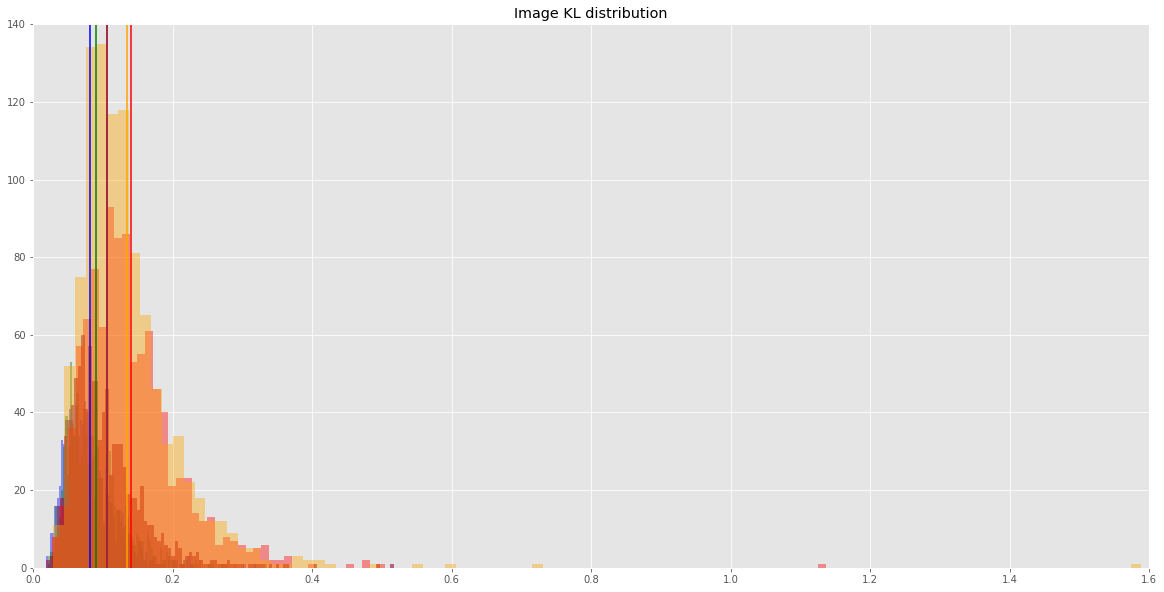

In [79]:
plt.figure(figsize=(20, 10))
kls = d_alphas["en1-en2"]
plt.hist(kls, bins=100, color="blue", alpha=0.4)
plt.axvline(np.mean(kls), color="blue")
kls = d_alphas["en1-en3"]
plt.hist(kls, bins=100, color="green", alpha=0.4)
plt.axvline(np.mean(kls), color="green")
kls = d_alphas["en1-en4"]
plt.hist(kls, bins=100, color="purple", alpha=0.4)
plt.axvline(np.mean(kls), color="purple")
kls = d_alphas["en1-en4"]
plt.hist(kls, bins=100, color="brown", alpha=0.4)
plt.axvline(np.mean(kls), color="brown")

kls = d_alphas["en1-de2"]
plt.hist(kls, bins=100, color="red", alpha=0.4)
plt.axvline(np.mean(kls), color="red")
kls = d_alphas["en1-de3"]
plt.hist(kls, bins=100, color="orange", alpha=0.4)
plt.axvline(np.mean(kls), color="orange")

plt.title("Image KL distribution")


# kls = d_alphas["en1-de2"]
# plt.hist(kls, bins=100, color="green", alpha=0.4)
# plt.axvline(np.mean(kls), color="green")
plt.ylim(0, 140)
plt.xlim(0, 1.6)

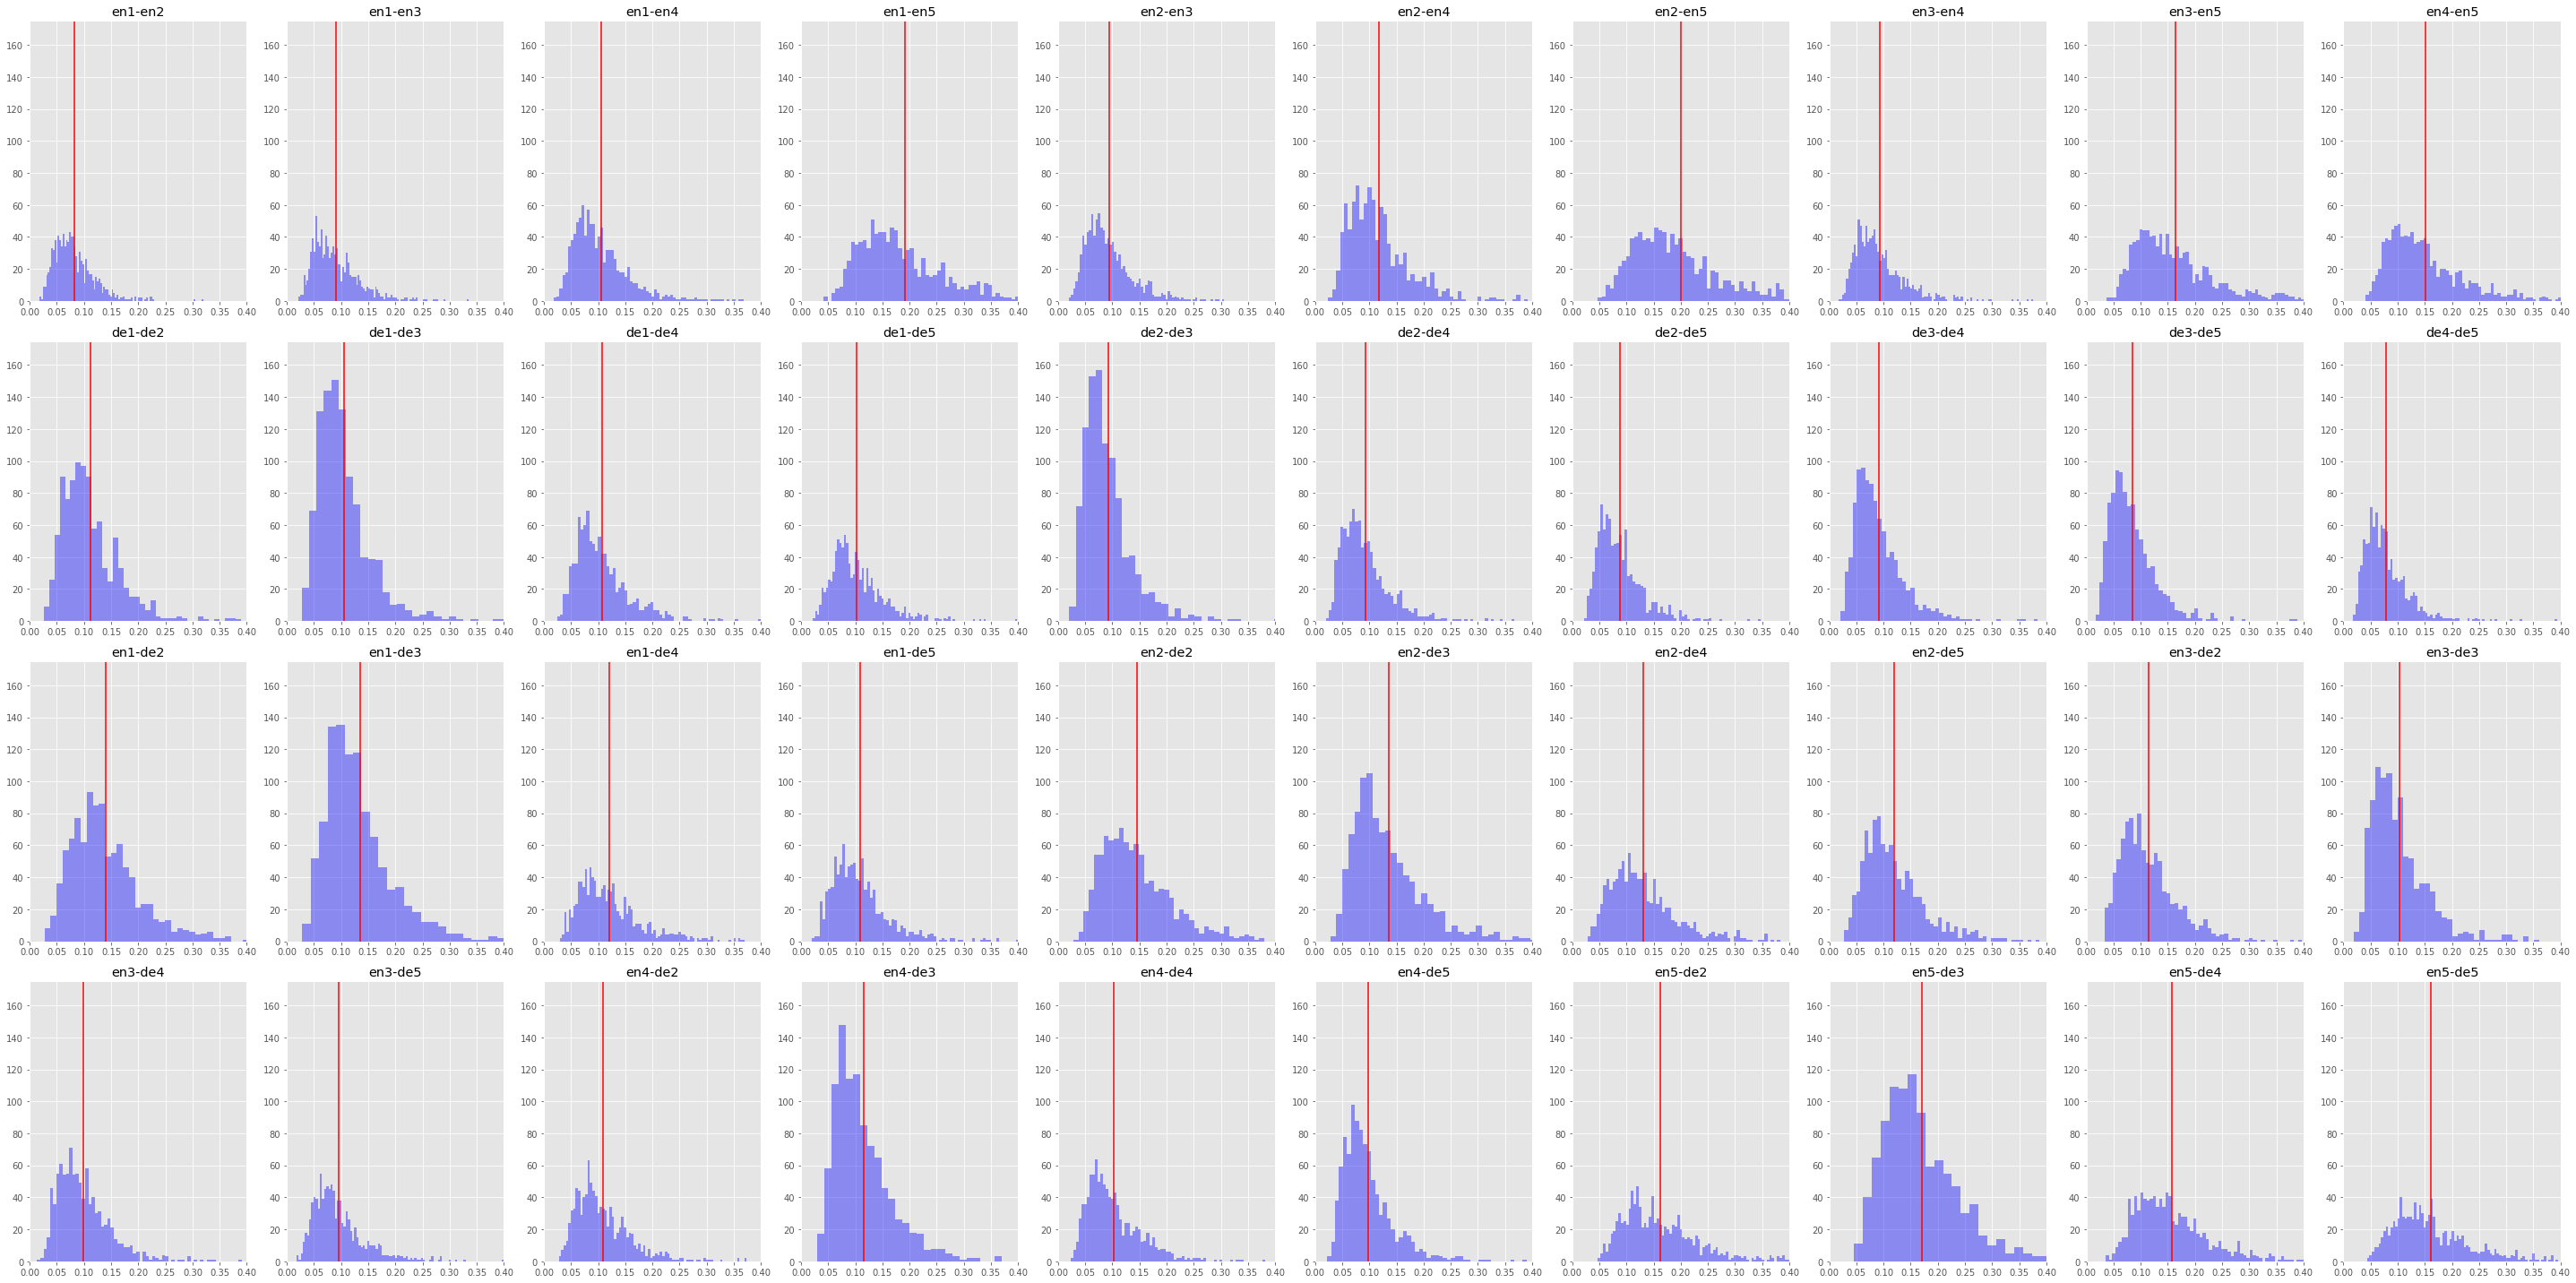

In [80]:
plt.figure(figsize=(40, 20))
for i, (comb, kls) in enumerate(d_alphas.items(), 1):
    plt.subplot(4, 10, i)
    plt.title("{}".format(comb))
    plt.hist(kls, bins=100, color="blue", alpha=0.4)
    plt.ylim(0, 175)
    plt.xlim(0, 0.4)
    plt.axvline(np.mean(kls), color="red")
plt.tight_layout()

In [81]:
d_kls = []
for i, (comb, kls) in enumerate(d_alphas.items(), 1):
    a, b = comb.split("-")
    lang1, lang2 = a[:-1], b[:-1]
    model1, model2 = a[-1], b[-1]
    for i, kl in enumerate(kls):
        d_kls.append({
            "img_idx": i,
            "kl": kl,
            "typ1": lang1,
            "typ2": lang2,
            "model1": model1,  
            "model2": model2,
            "type": "{}-{}".format(lang1, lang2)
        })
df_kls = pd.DataFrame(d_kls)

In [82]:
df_kls \
    .groupby("type")[["kl"]] \
    .aggregate({np.mean, np.std})

kl          
           mean       std
type                     
de-de  0.095609  0.054148
en-de  0.126395  0.070081
en-en  0.128951  0.080167

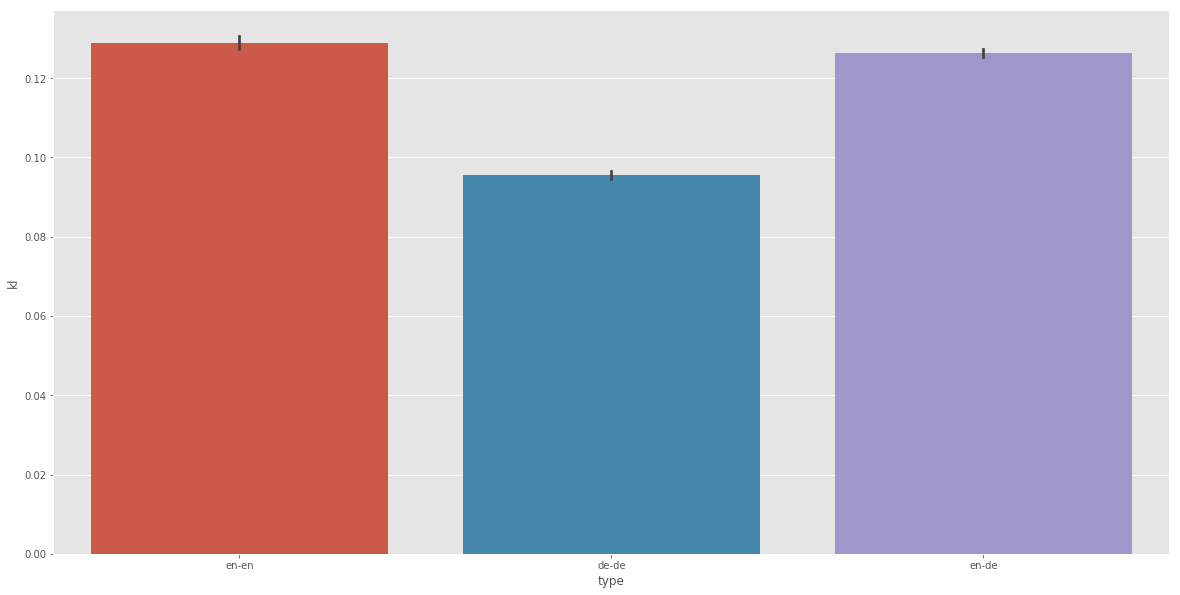

In [83]:
plt.figure(figsize=(20, 10))
sns.barplot(x="type", y="kl", ci=95, data=df_kls)

This is somewhat surprising. I would have expected that the within language KL's (`en-en`/`de-de`) would on average be lower than between language (`de-en`), howeever this doesn't seemt to be the case.

## Decoding from alphas and encodings

As a gut check we might want to see if we can decode from the language representations. We'll cast this as a binary classification task where inputs are hidden representations and outputs are the correspeonding language.

We'll compare three models.

1. Just alpha values.

2. Just LSTM hiddens.

3. Combo alphas an LSTM hiddens.

In [94]:
all_data["en1"]["all_avg_hiddens"]
all_data["en1"]["all_avg_alphas"][0].shape

(14, 14)

In [95]:
n_images = 1000
train_size = int(0.9 * n_images)
test_size = n_images - train_size
all_idxs = [i for i in range(n_images)]
train_idxs = np.random.choice(all_idxs, size=train_size, replace=False)
test_idxs = list(set(all_idxs) - set(train_idxs))

In [96]:
# Alphas
X_train_alphas_en = np.array(all_data["en1"]["all_avg_alphas"])[train_idxs].reshape((train_size, -1))
X_train_alphas_de = np.array(all_data["de1"]["all_avg_alphas"])[train_idxs].reshape((train_size, -1))
X_test_alphas_en = np.array(all_data["en1"]["all_avg_alphas"])[test_idxs].reshape((test_size, -1))
X_test_alphas_de = np.array(all_data["de1"]["all_avg_alphas"])[test_idxs].reshape((test_size, -1))
# Hiddens
X_train_hiddens_en = np.array(all_data["en1"]["all_avg_hiddens"])[train_idxs].reshape((train_size, -1))
X_train_hiddens_de = np.array(all_data["de1"]["all_avg_hiddens"])[train_idxs].reshape((train_size, -1))
X_test_hiddens_en = np.array(all_data["en1"]["all_avg_hiddens"])[test_idxs].reshape((test_size, -1))
X_test_hiddens_de = np.array(all_data["de1"]["all_avg_hiddens"])[test_idxs].reshape((test_size, -1))
# Combined
X_train_combined_en = np.append(X_train_alphas_en, X_train_hiddens_en, axis=1)
X_train_combined_de = np.append(X_train_alphas_de, X_train_hiddens_de, axis=1)
X_test_combined_en = np.append(X_test_alphas_en, X_test_hiddens_en, axis=1)
X_test_combined_de = np.append(X_test_alphas_de, X_test_hiddens_de, axis=1)

In [97]:
de_train_size = int(train_size / 2)
all_train_idxs = [i for i in range(train_size)]
train_de_idxs = np.random.choice(all_train_idxs, size=de_train_size, replace=False)
train_en_idxs = list(set(all_train_idxs) - set(train_de_idxs))

de_test_size = int(test_size / 2)
all_test_idxs = [i for i in range(test_size)]
test_de_idxs = np.random.choice(all_test_idxs, size=de_test_size, replace=False)
test_en_idxs = list(set(all_test_idxs) - set(test_de_idxs))

In [98]:
# Alphas
X_train_alphas = np.concatenate([X_train_alphas_en[train_en_idxs, :], X_train_alphas_de[train_de_idxs, :]])
X_test_alphas = np.concatenate([X_test_alphas_en[test_en_idxs, :], X_test_alphas_de[test_de_idxs, :]])
# Hiddens
X_train_hiddens = np.concatenate([X_train_hiddens_en[train_en_idxs, :], X_train_hiddens_de[train_de_idxs, :]])
X_test_hiddens = np.concatenate([X_test_hiddens_en[test_en_idxs, :], X_test_hiddens_de[test_de_idxs, :]])
# Combined
X_train_combined = np.concatenate([X_train_combined_en[train_en_idxs, :], X_train_combined_de[train_de_idxs, :]])
X_test_combined = np.concatenate([X_test_combined_en[test_en_idxs, :], X_test_combined_de[test_de_idxs, :]])
# Languages
y_train = [0 for _ in range(len(train_en_idxs))] + [1 for _ in range(len(train_de_idxs))]
y_test = [0 for _ in range(len(test_en_idxs))] + [1 for _ in range(len(test_de_idxs))]

datas = {
    "alphas": [X_train_alphas, X_test_alphas],
    "hiddens": [X_train_hiddens, X_test_hiddens],
    "combined": [X_train_combined, X_test_combined] }

assert(len(X_train_alphas)==train_size)
assert(len(y_train)==train_size)

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [100]:
model = LogisticRegression()

klassification_res = []
for typ, (train, test) in datas.items():
    klassification_res    
    model.fit(train, y_train)
    preds = model.predict(test)
    f1 = f1_score(y_test, preds)
    acc = accuracy_score(y_test, preds)
    klassification_res.append({
        "type": typ,
        "f1": f1,
        "acc": acc
    })
df_klassification = pd.DataFrame(klassification_res)

/Users/benpeloquin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/benpeloquin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/benpeloquin/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [101]:
df_klassification_melted = pd.melt(df_klassification, 
                                  id_vars=["type"], value_vars=["acc", "f1"], 
                                  var_name="measure", value_name="value")
df_klassification_melted.head()

type measure     value
0    alphas     acc  0.740000
1   hiddens     acc  1.000000
2  combined     acc  1.000000
3    alphas      f1  0.729167
4   hiddens      f1  1.000000

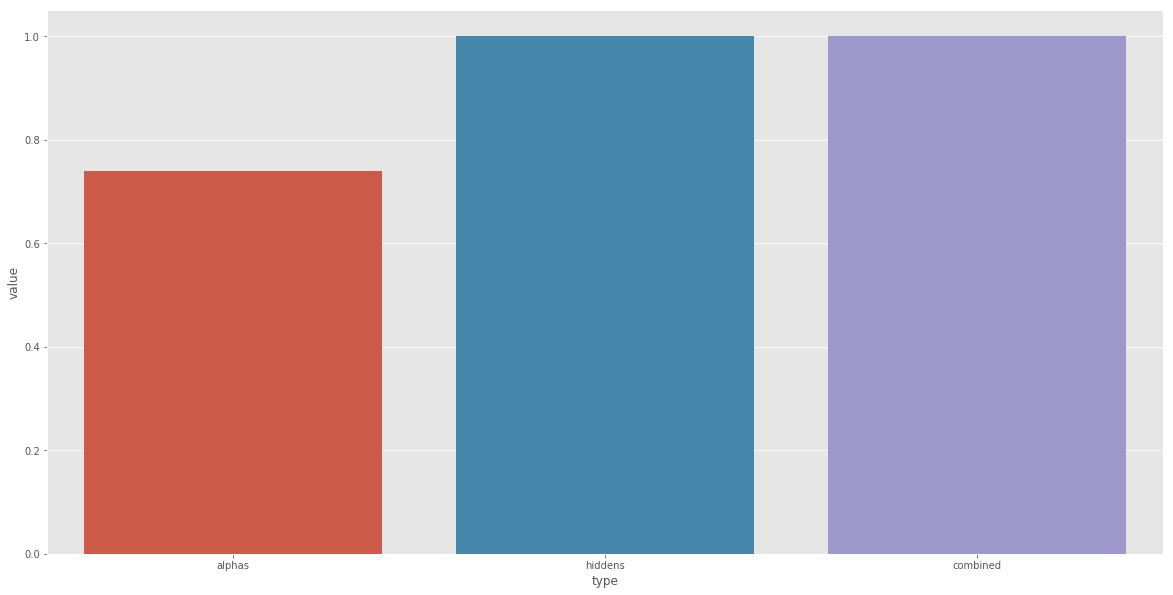

In [102]:
plt.figure(figsize=(20, 10))
sns.barplot(x="type", y="value", data=df_klassification_melted[df_klassification_melted["measure"]=="acc"])

So we can definitely tell what the langauge is by the hiddens... Suprisingly, we can also tell fairly reliably just based on the alpha distributions which means that the languages seem a bit biased in their attention distributions... This is kind of worrisome and may mean that the image captionin models made need further fine-tuning...